<a href="https://colab.research.google.com/github/Wpiroupo/Exercicio-Analise-Python/blob/main/Case_Teste_Python_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependência de Bibliotecas

In [ ]:
## Instala e importa todas as bibliotecas

# Pacote de atualização para leitura de arquivo ".xls"
!pip install --upgrade xlrd

# Tratamento das bases
import pandas as pd
import numpy as np
import datetime

# Graficos
import matplotlib as mlp
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Deletar o output
from IPython.display import clear_output 
clear_output()
import warnings
warnings.filterwarnings("ignore")

#Modelagem
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

print("Dependências Carregadas")

Dependências Carregadas


### Leitura do arquivo

In [ ]:
# Faz a leitura da base (peguei o caminho onde salvei o arquivo no Drive)

arquivo = "case_internacao_SUS.xls"
arquivo = pd.read_excel(arquivo, sheet_name=None) #Sheet_name=None para pegar todas as abas

# 1. Tratamento dos dados

In [ ]:
# Junta todas as planilhas em um DataFrame


# For loop pegar o nome da aba colocar em uma coluna e juntar elas em um df master

todas_abas = []

for name, sheet in arquivo.items():
    sheet['sheet'] = name
    sheet = sheet.rename(columns=lambda x: x.split('\n')[-1])
    todas_abas.append(sheet)

df = pd.concat(todas_abas)
df.reset_index(inplace=True, drop=True)

print("Aqui temos o DF completo com a coluna trazendo a Data")

Aqui temos o DF completo com a coluna trazendo a Data


In [ ]:
# Renomear colunas (gosto de tratar as colunas sem assento, sem ç e separada por _)

df.rename( columns={
    'Região/Unidade da Federação' : 'regiao_unidade_da_federacao',
    'Internações' : 'internacoes',
    'AIH_aprovadas' : 'aih_aprovadas',
    'Valor_total' : 'valor_total',
    'Valor_serviços_hospitalares' : 'valor_servicos_hospitalares',
    'Val_serv_hosp_-_compl_federal' : 'val_serv_hosp_compl_federal',
    'Val_serv_hosp_-_compl_gestor': 'val_serv_hosp_compl_gestor',
    'Valor_serviços_profissionais': 'valor_servicos_profissionais',
    'Val_serv_prof_-_compl_federal': 'val_serv_prof_compl_federal',
    'Val_serv_prof_-_compl_gestor': 'val_serv_prof_compl_gestor',
    'Valor_médio_AIH': 'valor_medio_aih',
    'Valor_médio_intern': 'valor_medio_intern',
    'Dias_permanência': 'dias_permanencia',
    'Média_permanência': 'media_permanencia',
    'Óbitos': 'obitos',
    'Taxa_mortalidade': 'taxa_mortalidade',
    'sheet': 'mes_ano'
}, inplace=True )

In [ ]:
#Ajustar a primeira coluna e separar região e estado

if 'estado' not in df:
    df_regiao = df['regiao_unidade_da_federacao'].str.split('Região', expand=True)
    df_regiao = df_regiao.fillna(method='ffill')
    df_regiao.rename(columns = {0 : 'estado', 1 : 'regiao'}, inplace = True)
    df = pd.concat([df,df_regiao], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   regiao_unidade_da_federacao   475 non-null    object 
 1   internacoes                   461 non-null    float64
 2   aih_aprovadas                 461 non-null    float64
 3   valor_total                   461 non-null    float64
 4   valor_servicos_hospitalares   461 non-null    float64
 5   val_serv_hosp_compl_federal   461 non-null    object 
 6   val_serv_hosp_compl_gestor    461 non-null    object 
 7   valor_servicos_profissionais  461 non-null    float64
 8   val_serv_prof_compl_federal   461 non-null    object 
 9   val_serv_prof_compl_gestor    461 non-null    object 
 10  valor_medio_aih               461 non-null    float64
 11  valor_medio_intern            461 non-null    float64
 12  dias_permanencia              461 non-null    float64
 13  media

In [ ]:
#Configura visualização dos floats

pd.options.display.float_format = '{:,.2f}'.format


# Transforma em formato numerico, caso de erro preenche NaN

df['val_serv_hosp_compl_federal'] = pd.to_numeric(df['val_serv_hosp_compl_federal'], errors='coerce')
df['val_serv_hosp_compl_gestor'] = pd.to_numeric(df['val_serv_hosp_compl_gestor'], errors='coerce')
df['val_serv_prof_compl_federal'] = pd.to_numeric(df['val_serv_prof_compl_federal'], errors='coerce')
df['val_serv_prof_compl_gestor'] = pd.to_numeric(df['val_serv_prof_compl_gestor'], errors='coerce')


# 2 Métodos para preencher os dados vazios 

# 1º Dei preferencia em preencher de forma linear

df['val_serv_hosp_compl_federal'] = df['val_serv_hosp_compl_federal'].interpolate()
df['val_serv_hosp_compl_gestor'] = df['val_serv_hosp_compl_gestor'].interpolate()
df['val_serv_prof_compl_federal'] = df['val_serv_prof_compl_federal'].interpolate()
df['val_serv_prof_compl_gestor'] = df['val_serv_prof_compl_gestor'].interpolate()

# 2º Preencher com a média

media = df['val_serv_hosp_compl_federal'].mean()
df['val_serv_hosp_compl_federal'] = df['val_serv_hosp_compl_federal'].fillna(media)
media = df['val_serv_hosp_compl_gestor'].mean()
df['val_serv_hosp_compl_gestor'] = df['val_serv_hosp_compl_gestor'].fillna(media)
media = df['val_serv_prof_compl_federal'].mean()
df['val_serv_prof_compl_federal'] = df['val_serv_prof_compl_federal'].fillna(media)
media = df['val_serv_prof_compl_gestor'].mean()
df['val_serv_prof_compl_gestor'] = df['val_serv_prof_compl_gestor'].fillna(media)


# Remover dados vazios/insignificantes

df = df[df.regiao_unidade_da_federacao != ' ']
df = df[df.estado != ''] # se esta vazio é porque é região
df = df[df.estado != 'Total']


# Remove os 2 pontos na frente do estado

for row in df['regiao_unidade_da_federacao']:
    try:
        if '..' in row:
          df['regiao_unidade_da_federacao'] = df['regiao_unidade_da_federacao'].str[2:]
          df['estado'] = df['estado'].str[2:] 
    except TypeError:
        pass

In [ ]:
# consultar se possui algum campo vazio

print(df.isnull().sum())

regiao_unidade_da_federacao     0
internacoes                     0
aih_aprovadas                   0
valor_total                     0
valor_servicos_hospitalares     0
val_serv_hosp_compl_federal     0
val_serv_hosp_compl_gestor      0
valor_servicos_profissionais    0
val_serv_prof_compl_federal     0
val_serv_prof_compl_gestor      0
valor_medio_aih                 0
valor_medio_intern              0
dias_permanencia                0
media_permanencia               0
obitos                          0
taxa_mortalidade                0
mes_ano                         0
estado                          0
regiao                          0
dtype: int64


In [ ]:
# Formatando a data 

ajustar_mes_ano = {'jul19': '07-2019', 'jun19': '06-2019',
                   'dez17': '12-2017', 'mar18': '03-2018',
                   'abr19': '04-2019', 'abr18': '04-2018',
                   'mai18': '05-2018', 'jul18': '07-2018',
                   'ago18': '08-2018', 'set18': '09-2018',
                   'nov18': '11-2018', 'dez18': '12-2018',
                   'jan19': '01-2019', 'fev19': '02-2019',
                   }


# Transformando objeto em data

for row in df['mes_ano']:
    try:
        if 'jul19' in row:
          df['mes_ano'] = df['mes_ano'].map(ajustar_mes_ano)  
    except TypeError:
      pass
      
df['mes_ano'] =  pd.to_datetime(df['mes_ano'], format='%m-%Y')

# Crio colunas

df['mes'] = pd.DatetimeIndex( df['mes_ano'] ).month
df['ano'] = pd.DatetimeIndex( df['mes_ano'] ).year
df["periodo"] = df['ano'].astype(str) +"-"+ df["mes"].astype(str)

In [ ]:
# Verifico 5 primeiras linhas

df.head()

,regiao_unidade_da_federacao,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_servicos_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,...,dias_permanencia,media_permanencia,obitos,taxa_mortalidade,mes_ano,estado,regiao,mes,ano,periodo
1,Rondônia,"9,603.00","9,603.00","9,404,751.41","7,666,945.90","141,673.30","121,005.89","1,737,805.51","121,005.89","95,807.04",...,"53,043.00",5.50,315.00,3.28,2019-07-01,Rondônia,Norte,7,2019,2019-7
2,Amazonas,"16,248.00","16,248.00","15,624,312.73","12,166,634.07","1,221.31","121,005.89","3,455,637.92","121,005.89","95,807.04",...,"85,512.00",5.30,536.00,3.30,2019-07-01,Amazonas,Norte,7,2019,2019-7
3,Roraima,"4,324.00","4,324.00","3,137,537.40","2,356,231.68","124,709.28","121,005.89","781,305.72","121,005.89","95,807.04",...,"25,560.00",5.90,171.00,3.95,2019-07-01,Roraima,Norte,7,2019,2019-7
4,Pará,"34,774.00","34,774.00","28,178,633.44","21,241,354.07","248,197.25","121,005.89","6,581,738.70","121,005.89","95,807.04",...,"138,135.00",4.00,832.00,2.39,2019-07-01,Pará,Norte,7,2019,2019-7
5,Amapá,"3,407.00","3,407.00","2,380,727.69","1,776,869.35","140,451.98","121,005.89","603,858.34","121,005.89","95,807.04",...,"18,703.00",5.50,85.00,2.49,2019-07-01,Amapá,Norte,7,2019,2019-7


#2. Análises

In [ ]:
# Dicionario para agregar e somar ou fazer a média das respectivas colunas

f = {
    'internacoes': 'sum', 'aih_aprovadas': 'sum', 'obitos': 'sum',
     'dias_permanencia': 'sum', 'valor_total': 'sum', 'valor_servicos_hospitalares': 'sum',
     'val_serv_hosp_compl_federal': 'sum', 'val_serv_hosp_compl_gestor': 'sum', 'valor_servicos_profissionais': 'sum',
     'val_serv_prof_compl_federal': 'sum', 'val_serv_prof_compl_gestor': 'sum',
     'valor_medio_aih': 'mean', 'valor_medio_intern': 'mean',
     'media_permanencia': 'mean', 'taxa_mortalidade': 'mean',
     }

df_analise = df.groupby( by=['periodo', 'regiao', 'estado'], as_index=False).agg(f)
df_analise['mes_ano'] =  pd.to_datetime(df_analise['periodo'], format='%Y-%m')

In [ ]:
# Big Numbers das bases tratadas

big_numbers = df_analise.agg(f)
big_numbers = big_numbers.to_frame().reset_index()
big_numbers.rename(columns={'index': 'Dimensões', 0: 'Geral'}, inplace=True)
big_numbers

,Dimensões,Geral
0,internacoes,"13,847,256.00"
1,aih_aprovadas,"14,058,491.00"
2,obitos,"592,066.00"
3,dias_permanencia,"73,435,619.00"
4,valor_total,"17,828,294,649.57"
5,valor_servicos_hospitalares,"14,166,408,187.72"
6,val_serv_hosp_compl_federal,"141,337,890.41"
7,val_serv_hosp_compl_gestor,"38,788,847.07"
8,valor_servicos_profissionais,"3,529,963,045.75"
9,val_serv_prof_compl_federal,"38,788,847.07"


In [ ]:
# Comportamento Geral ao longo do tempo 

metricas_no_tempo = df_analise.groupby(['periodo']).agg(f)
metricas_no_tempo
# Percebemos a falta de dados no meio do periodo

,internacoes,aih_aprovadas,obitos,dias_permanencia,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_servicos_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,media_permanencia,taxa_mortalidade
periodo,,,,,,,,,,,,,,,
2017-12,"939,601.00","956,065.00","38,881.00","5,049,429.00","1,201,828,188.24","949,813,827.09","13,655,844.11","7,800,370.78","239,248,735.74","7,800,370.78","7,153,122.76","1,109.12","1,123.63",5.20,3.60
2018-11,"968,423.00","982,967.00","40,078.00","5,105,444.00","1,254,140,698.63","992,459,967.46","15,356,575.87","2,170,650.18","247,067,490.17","2,170,650.18","2,037,310.18","1,133.47","1,145.59",5.23,3.73
2018-12,"932,863.00","947,528.00","39,281.00","4,935,608.00","1,218,271,415.11","964,603,413.09","14,055,740.43","2,274,620.92","239,867,737.36","2,274,620.92","1,824,313.65","1,139.33","1,152.19",5.19,3.69
2018-3,"994,222.00","1,010,157.00","40,490.00","5,236,604.00","1,249,570,771.57","990,702,315.34","7,664,000.35","5,388,386.43","251,090,573.15","5,388,386.43","3,463,513.05","1,104.23","1,117.13",5.15,3.63
2018-4,"1,006,271.00","1,022,183.00","41,111.00","5,305,641.00","1,265,569,345.19","1,004,415,469.78","8,898,027.77","1,799,950.64","253,609,310.40","1,799,950.64","1,470,308.93","1,099.85","1,112.55",5.20,3.73
2018-5,"1,018,405.00","1,034,183.00","42,508.00","5,392,075.00","1,279,917,419.73","1,016,152,683.85","8,391,230.46","2,781,617.19","255,952,551.51","2,781,617.19","1,792,395.72","1,089.77","1,102.14",5.21,3.76
2018-7,"1,014,016.00","1,029,452.00","45,595.00","5,467,752.00","1,301,462,492.89","1,034,695,987.66","9,530,801.90","1,963,174.71","257,597,898.22","1,963,174.71","1,398,389.77","1,119.01","1,131.47",5.26,3.99
2018-8,"1,020,220.00","1,035,363.00","44,550.00","5,447,625.00","1,316,574,487.52","1,048,667,158.94","8,213,519.04","1,937,981.04","260,668,164.88","1,937,981.04","1,459,192.70","1,125.49","1,137.65",5.27,3.80
2018-9,"988,931.00","1,003,982.00","42,720.00","5,239,754.00","1,272,478,809.49","1,010,881,403.23","11,045,821.37","2,177,423.59","252,496,783.89","2,177,423.59","1,541,721.14","1,122.48","1,134.69",5.15,3.78


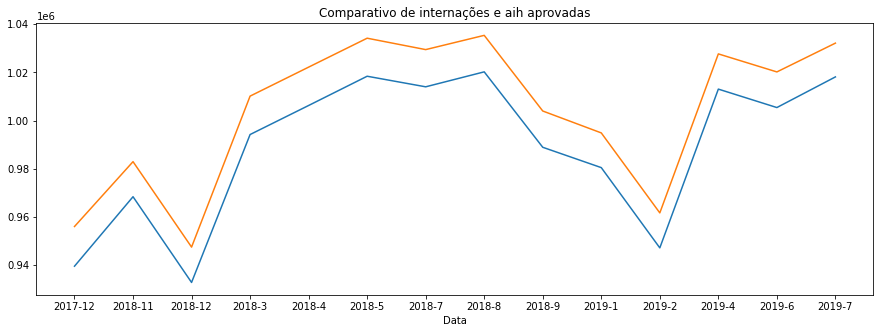

In [ ]:
# Grafico do tempo

plt.figure(figsize=[15, 5])
plt.plot(metricas_no_tempo.index,
         metricas_no_tempo['internacoes'],
         metricas_no_tempo['aih_aprovadas'],
         )
plt.xlabel("Data")
plt.title("Comparativo de internações e aih aprovadas");
# Aprovações de AIH segue conforme as internações
# Numero de internações mais baixa no final/Começo de ano

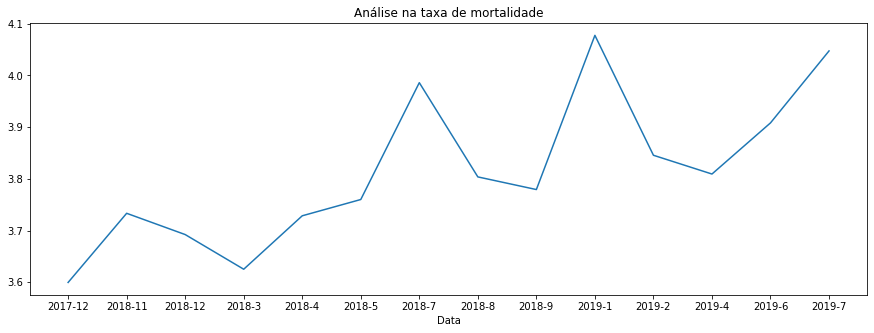

In [ ]:
# Grafico do tempo

plt.figure(figsize=[15, 5])
plt.plot(metricas_no_tempo.index,
         metricas_no_tempo['taxa_mortalidade'],
         )
plt.xlabel("Data")
plt.title("Análise na taxa de mortalidade");
# esta crescendo oq podemos fazer para diminuir

In [ ]:
#Descrições estatisticas das principais métricas

df_analise[['internacoes', 'dias_permanencia', 'media_permanencia', 'obitos', 'taxa_mortalidade', 'valor_total', 'valor_medio_intern']].describe()
# count = Contagem de quantas vezes aparece na base
# mean = média dos valores das respectivas colunas
# std = desvio padrão
# min = valor mínimo
# 25% = 
# 50% = mediana
# 75% = 
# max = valor máximo

,internacoes,dias_permanencia,media_permanencia,obitos,taxa_mortalidade,valor_total,valor_medio_intern
count,377.00,377.00,377.00,377.00,377.00,377.00,377.00
mean,"36,730.12","194,789.44",5.23,"1,570.47",3.81,"47,289,906.23","1,139.47"
std,"41,822.12","233,046.49",0.71,"2,134.88",1.01,"60,559,440.10",263.35
min,"2,493.00","12,648.00",4.00,71.00,2.02,"1,716,855.56",622.21
25%,"13,815.00","66,906.00",4.70,467.00,3.16,"14,813,113.79",919.66
50%,"18,548.00","95,532.00",5.10,697.00,3.72,"21,652,391.73","1,157.55"
75%,"45,745.00","251,960.00",5.60,"1,991.00",4.32,"64,648,373.69","1,370.80"
max,"215,787.00","1,192,857.00",8.00,"11,988.00",7.43,"304,314,139.97","1,725.63"


In [ ]:
# Analisar por mês para tentar encontrar algum padrao entre intenações e o valor aprovado da produção por data

df_analise.groupby(['mes_ano']).describe()[['internacoes', 'valor_total']]

# Menor número de internações foi em dezembro de 2017 coincidentemente no primeiro mes da base 
# Já o maior internações foi em Abril de 2019 um dos ultimos meses da base, podendo concluirmos que esta crescendo o numero de internações

# Percebemos que em Dezembro de 2017 tivemos a menor média e o menor valor aprovado da produção.
# Já em Julho de 2019 tivemos a maior média e o maior valor aprovado na produção, sendo ela o ultimo periodo da base podemos concluir que esta crescendo.

# Conclusão: Se compararmos tanto as internações quanto o valor aprovado da produção de 2017 podemos ver que esta crescendo ao longo do tempo 

internacoes                                                   \
                 count      mean       std      min       25%       50%   
mes_ano                                                                   
2017-12-01       27.00 34,800.04 40,562.11 2,493.00 13,006.50 17,763.00   
2018-03-01       27.00 36,823.04 43,124.45 3,018.00 13,874.00 18,425.00   
2018-04-01       27.00 37,269.30 43,128.67 2,723.00 14,320.00 18,292.00   
2018-05-01       27.00 37,718.70 43,483.99 2,504.00 14,739.00 18,943.00   
2018-07-01       27.00 37,556.15 42,865.19 2,897.00 14,804.50 20,408.00   
2018-08-01       27.00 37,785.93 43,570.07 3,506.00 14,063.00 20,517.00   
2018-09-01       27.00 36,627.07 41,931.32 3,471.00 14,370.50 18,002.00   
2018-11-01       27.00 35,867.52 41,540.06 3,438.00 13,950.00 17,380.00   
2018-12-01       27.00 34,550.48 40,567.84 2,580.00 12,842.00 18,112.00   
2019-01-01       27.00 36,314.67 42,138.24 3,274.00 13,850.50 18,401.00   
2019-02-01       27.00 35,081.56 40,658.04 2,899.00 13,649.00 18,473.00   
2019-04-01       27.00 37,520.93 44,077.92 3,037.00 14,350.50 19,459.00   
2019-06-01       27.00 37,237.63 43,220.11 3,166.00 14,651.50 18,765.00   
2019-07-01       26.00 39,158.65 44,582.00 3,407.00 15,441.00 20,810.50   

                                valor_total                              \
                 75%        max       count          mean           std   
mes_ano                                                                   
2017-12-01 43,217.00 198,083.00       27.00 44,512,155.12 58,898,151.60   
2018-03-01 45,111.00 211,205.00       27.00 46,280,398.95 60,497,498.93   
2018-04-01 45,343.00 210,204.00       27.00 46,872,938.71 61,142,944.73   
2018-05-01 46,535.00 212,696.00       27.00 47,404,348.88 61,925,710.33   
2018-07-01 45,322.00 207,804.00       27.00 48,202,314.55 62,216,828.01   
2018-08-01 46,154.00 212,547.00       27.00 48,762,018.06 63,370,943.37   
2018-09-01 44,336.00 203,113.00       27.00 47,128,844.80 60,726,594.74   
2018-11-01 43,375.50 201,634.00       27.00 46,449,655.50 60,454,319.10   
2018-12-01 41,368.00 197,493.00       27.00 45,121,163.52 59,916,690.44   
2019-01-01 44,994.00 205,741.00       27.00 47,704,888.15 62,829,876.30   
2019-02-01 42,811.00 197,813.00       27.00 45,420,820.95 59,362,255.04   
2019-04-01 46,380.50 215,787.00       27.00 48,112,946.37 62,936,281.75   
2019-06-01 45,530.50 209,812.00       27.00 48,248,513.67 62,323,111.10   
2019-07-01 48,313.50 214,299.00       26.00 52,012,594.41 65,720,346.53   

                                                                   \
                    min           25%           50%           75%   
mes_ano                                                             
2017-12-01 1,716,855.56 13,970,196.16 18,311,840.01 59,352,082.89   
2018-03-01 1,882,553.32 15,117,813.37 20,340,897.78 63,036,316.87   
2018-04-01 1,781,034.49 15,461,596.62 20,774,806.62 63,390,150.36   
2018-05-01 1,821,567.42 15,368,098.43 20,789,038.18 65,836,636.73   
2018-07-01 1,910,968.09 15,617,125.30 22,301,468.16 66,009,938.53   
2018-08-01 2,453,555.40 14,998,453.04 23,318,726.05 66,642,624.43   
2018-09-01 2,619,709.86 15,724,620.36 20,307,075.79 64,221,472.63   
2018-11-01 2,139,141.93 15,102,138.77 20,581,258.13 62,068,665.86   
2018-12-01 2,123,426.26 13,902,357.94 17,413,559.67 59,514,172.38   
2019-01-01 2,527,888.58 15,031,413.82 22,502,654.14 62,816,546.81   
2019-02-01 1,906,429.95 14,816,027.63 20,181,200.29 60,204,929.80   
2019-04-01 2,411,628.00 15,721,218.73 21,818,613.00 62,993,684.70   
2019-06-01 2,109,126.09 15,888,746.60 21,491,971.56 65,680,986.53   
2019-07-01 2,380,727.69 16,130,470.16 25,197,394.04 69,390,504.00   

                           
                      max  
mes_ano                    
2017-12-01 280,080,500.10  
2018-03-01 286,775,733.92  
2018-04-01 289,711,791.16  
2018-05-01 293,104,281.74  
2018-07-01 291,524,922.05  
2018-08-01 298,702,204.56  
2018-09-01 282,739,086.76  
2018-

In [ ]:
# Variaveis para facilitar nos graficos

# estados com maiores numeros de internações
internacoes_por_regiao = df_analise.groupby( by=['regiao'] ).sum()['internacoes'].reset_index()
internacoes_por_regiao = internacoes_por_regiao.sort_values(['internacoes'], ascending=[False])

# estados com maiores numeros de internações
internacoes_por_estado = df_analise.groupby( by=['estado'] ).sum()['internacoes'].reset_index()
internacoes_por_estado = internacoes_por_estado.sort_values(['internacoes'], ascending=[False])

# estados com maiores numeros de internações
internacoes_por_data = df_analise.groupby( by=['mes_ano'] ).sum()['internacoes'].reset_index()
internacoes_por_data = internacoes_por_data.sort_values(['mes_ano'], ascending=[False])

# Monta um Geral com os estados
df_estados = df_analise.groupby(['estado'], as_index=False).agg(f)
df_regiao = df_analise.groupby(['regiao'], as_index=False).agg(f)

In [ ]:
fig = px.bar(df_analise, x="periodo", y="internacoes", color="regiao", title="Análise das internações por Região ao longo do tempo")
fig.show()
# Percebemos a falta de alguns dados 
# maior regiao onde tem internação é no sudeste

In [ ]:
fig = px.bar(internacoes_por_regiao, x='regiao', y='internacoes', title='Análise da quantidade de internações por regiao')
fig.show()
# coneseguimos visualizar as maiore regioes com internações

In [ ]:
fig = px.bar(internacoes_por_estado, x='estado', y='internacoes', barmode='stack', title='Análise quantidade de Internações por estado')
fig.show()
# Identificamos os maiores estados em quantidade de internações

São Paulo é disparado o maior numero de casos de internação.

- Possuimos algumas datas vazias, como preenchelas?

- Qual seria uma possivel solução para diminui-la?

#3. Modelagem 3.1 e 3.2




In [ ]:
# precisamos preencher as datas falntantes da nossa base: '2018-01, 2018-02, 2018-06, 2018-10, 2019-03, 2019-05'

In [ ]:
# separei as duplicadas do mes_ano para preencher com os meses restantes

df_geral = df_analise.groupby(['mes_ano'], as_index=False).agg(f)
df_geral['mes_ano'] = pd.to_datetime(df_geral['mes_ano'])
df_geral = (df_geral.set_index('mes_ano')
      .reindex(pd.date_range('2017-12-01', '2019-07-01', freq='MS'))
      .rename_axis(['mes_ano'])
      .fillna(0)
      .reset_index())


# Podemos prencheer com o valor mais próximo, tanto anterior quanto do seguint ou média
# Utilizei preenchendo igual o valor do proximo do seguinte 

df_geral = df_geral.replace(0, np.nan)
df_geral = df_geral.fillna(method="bfill")

In [ ]:
# preenchimento dos dados para analisar sao paulo

df_sp = df_analise[df_analise['estado'].str.contains("São Paulo")]


# Preencher dados vazios

df_sp = (df_sp.set_index('mes_ano')
      .reindex(pd.date_range('2017-12-01', '2019-07-01', freq='MS'))
      .rename_axis(['mes_ano'])
      .fillna(0)
      .reset_index())
df_sp = df_sp.replace(0, np.nan)
df_sp = df_sp.fillna(method="bfill")

Análise de correlações Geral


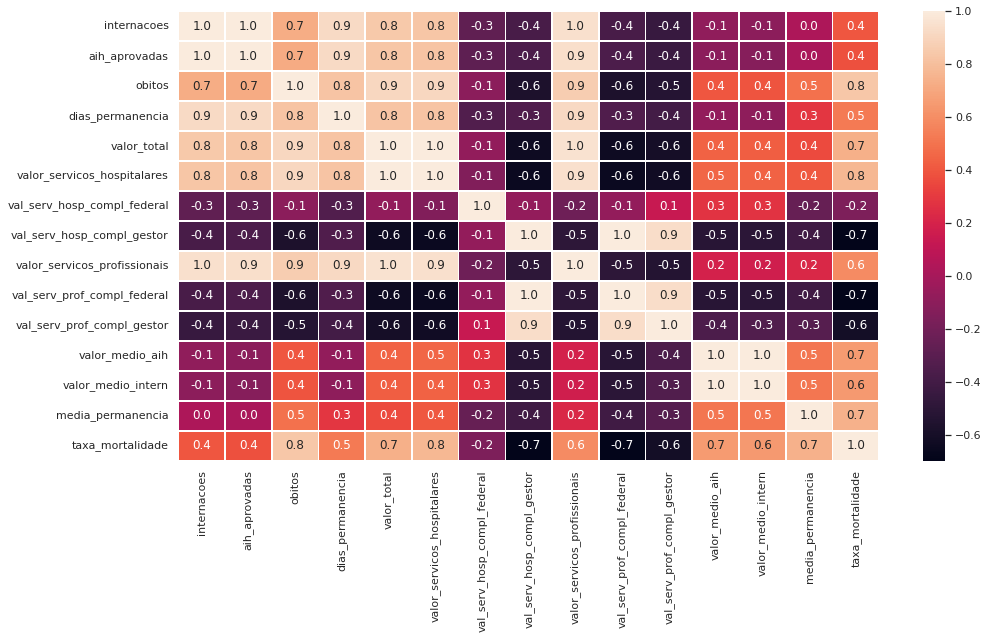

In [ ]:
# análise de correlação
df_geral_corr = df_geral[['internacoes', 'aih_aprovadas', 'obitos', 'dias_permanencia',
                          'valor_total', 'valor_servicos_hospitalares','val_serv_hosp_compl_federal',
                          'val_serv_hosp_compl_gestor','valor_servicos_profissionais',
                          'val_serv_prof_compl_federal','val_serv_prof_compl_gestor',
                          'valor_medio_aih', 'valor_medio_intern','media_permanencia',
                          'taxa_mortalidade']]
correlation = df_geral.corr()

# plot da matriz de correlação
sns.set(rc={'figure.figsize':(15.7,8.27)})
plot_geral = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
print('Análise de correlações Geral')
plot_geral;

Análise de correlações em São Paulo


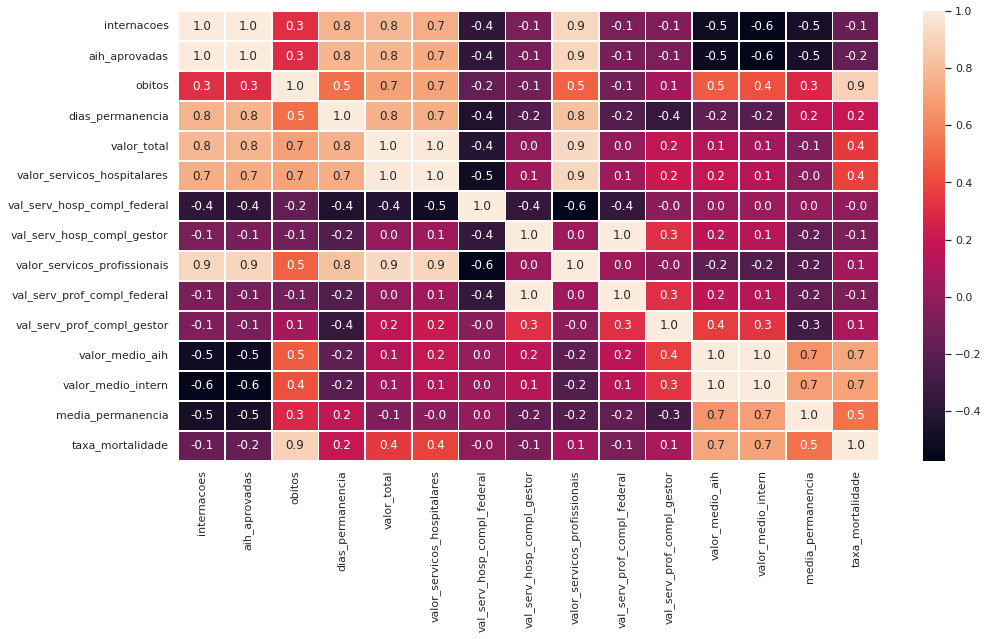

In [ ]:
# análise de correlação
df_geral_corr = df_sp[['internacoes', 'aih_aprovadas', 'obitos', 'dias_permanencia',
                          'valor_total', 'valor_servicos_hospitalares','val_serv_hosp_compl_federal',
                          'val_serv_hosp_compl_gestor','valor_servicos_profissionais',
                          'val_serv_prof_compl_federal','val_serv_prof_compl_gestor',
                          'valor_medio_aih', 'valor_medio_intern','media_permanencia',
                          'taxa_mortalidade']]
correlation = df_sp.corr()

# plot da matriz de correlação
sns.set(rc={'figure.figsize':(15.7,8.27)})
plot_sp = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
print('Análise de correlações em São Paulo')
plot_sp;

#3. Modelagem 3.3

Crie um modelo que preveja a) as Internações, b) o número de Óbitos e c) o
Valor Médio de AIH pelos próximos 6 meses. Explique a escolha do modelo e
quais parâmetros utilizou para serem input no modelo.

In [ ]:
df = df_geral[['mes_ano', 'internacoes', 'obitos', 'valor_medio_aih']]
df.set_index('mes_ano', inplace=True)

In [ ]:
df.describe()

,internacoes,obitos,valor_medio_aih
count,20.00,20.00,20.00
mean,"991,831.00","42,250.10","1,125.57"
std,"27,255.20","2,422.44",20.18
min,"932,863.00","38,881.00","1,089.77"
25%,"977,477.75","40,387.00","1,107.90"
50%,"999,819.00","41,806.00","1,129.47"
75%,"1,013,302.75","44,477.00","1,136.98"
max,"1,020,220.00","46,924.00","1,175.48"


In [ ]:
values = pd.DataFrame(df.values)

In [ ]:
df_2 = pd.concat([values, values.shift(1)], axis=1 )

In [ ]:
df_2.columns = ['internacoes', 'obitos', 'valor_medio_aih', 'predict_internacoes', 'predict_obitos', 'predict_valor_medio_aih']

In [ ]:
df_2.head()

,internacoes,obitos,valor_medio_aih,predict_internacoes,predict_obitos,predict_valor_medio_aih
0,"939,601.00","38,881.00","1,109.12",NaN,NaN,NaN
1,"994,222.00","40,490.00","1,104.23","939,601.00","38,881.00","1,109.12"
2,"994,222.00","40,490.00","1,104.23","994,222.00","40,490.00","1,104.23"
3,"994,222.00","40,490.00","1,104.23","994,222.00","40,490.00","1,104.23"
4,"1,006,271.00","41,111.00","1,099.85","994,222.00","40,490.00","1,104.23"


In [ ]:
df_test = df_2[1:] 

In [ ]:
df_error_internacoes = mean_squared_error(df_test.internacoes, df_test.predict_internacoes)

In [ ]:
erro_internacao = np.sqrt(df_error_internacoes)
print(f'erro_internacao: {erro_internacao}')

erro_internacao: 27079.868125310553


In [ ]:
df.describe()

,internacoes,obitos,valor_medio_aih
count,20.00,20.00,20.00
mean,"991,831.00","42,250.10","1,125.57"
std,"27,255.20","2,422.44",20.18
min,"932,863.00","38,881.00","1,089.77"
25%,"977,477.75","40,387.00","1,107.90"
50%,"999,819.00","41,806.00","1,129.47"
75%,"1,013,302.75","44,477.00","1,136.98"
max,"1,020,220.00","46,924.00","1,175.48"


In [ ]:
df_valor_medio_aih = df[['valor_medio_aih']]
df_internacoes = df[['internacoes']]
df_obitos = df[['obitos']]

In [ ]:
df_internacoes

df_model_internacoes = ARIMA(df_internacoes, order=(2,1,0) )
df_model_fit = df_model_internacoes.fit()
df_forecast = df_model_fit.forecast(steps = 6)[0]
df_model_fit.aic
print('Internações nos proximos meses:')
df_forecast

Internações nos proximos meses:


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



array([1018028.47358956, 1024760.45646378, 1026676.88754251,
       1031560.36526575, 1034497.25351579, 1038673.78444567])

In [ ]:
df_obitos

df_model_internacoes = ARIMA(df_obitos, order=(2,1,0) )
df_model_fit = df_model_internacoes.fit()
df_forecast = df_model_fit.forecast(steps = 6)[0]
df_model_fit.aic
print('obitos nos proximos meses:')
df_forecast

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



obitos nos proximos meses:


array([46761.40679047, 47825.80441186, 47943.64377171, 48592.52847971,
       48878.07236581, 49382.67629367])

In [ ]:
df_valor_medio_aih

df_model_internacoes = ARIMA(df_valor_medio_aih, order=(2,1,0) )
df_model_fit = df_model_internacoes.fit()
df_forecast = df_model_fit.forecast(steps = 6)[0]
df_model_fit.aic
print('Internações nos proximos meses:')
df_forecast

Internações nos proximos meses:


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



array([1168.41163885, 1174.01935075, 1176.65259006, 1179.93200374,
       1183.07571859, 1186.24747292])

#4. Planejamento Estratégico

4.1. Com base nos dados e nas suas análises, que tipo de estratégia você sugeriria
para diminuir o número de internações em hospitais do SUS? E para o Estado
de São Paulo? Quais especificidades deveriam ser levadas em conta?


**Estratégia para redução nos casos de internações geral:**

- Reduzir investimento no valor_servicos_hospitalares
- Reduzir investimento no valor serviços profissionais
- aumentar investimento no serviços hop compl federal
- aumentar investimento no serviços hop compl gestor	
- aumentar investimento no Val serv prof - compl federal
- aumentar investimento no Val serv prof - compl gestor

**Para São Paulo:**

- Aumentar o Valor médio Valor médio das AIH aprovadas no período.
- Aumentar o Valor médio das AIH aprovadas, computadas como internações, no período.
- Dar mais orientações ao tempo de permanencia entre os dias de baixa e alta de internação, para um aumento

**O que deve ser considerado?**
- Deve ser levado em conta onde os valores estão sendo investido no geral, e passar orientação para tentar aumentar o tempo médio de permanencia em internações em São Paulo

#Relatório Final

Graficos:

**analises, insights:** 
- O numero de aprovações de AIH seguem juntas com as internações
- A taxa de mortalidade nas internações tem aumentado ao longo do tempo 
- Fazendo as descrições estatisticas, percebemos que do 75% ao maximo de internações temos um aumento muito maior se comparado com o valor médio de internação deste mesmo periodo
- Numero de internações vem crescendo ao longo do tempo
- Conseguimos rankear as regioes com maiores numeros e seus comportamentos, sendo elas do maior para o menor: Sudeste, Nordeste, Sul, Norte, Centro-Oeste. Fizemos o mesmo para os estados
- Fizemos a correlação entre os dados para possiveis tomadas de decisões onde explico na parte das estratégias

**porque dos metodos citados no item 3.1 e 3.2?** 
- É um método simples e bastante eficiente quando nao tem muitos dados faltantes em sequencia, apenas prencher com o valor próximo da frente (que foi o utilizado), ou com uma média tende a ser bastante utilizado  

**modelagem requerida para predição dos 6 meses:**
- Foi utilizado o modelo ARIMA usando dois principais recursos: 
- 1- autocorrelação 
- 2- médias móveis

**Estratégia para redução nos casos de internações geral:**

- Reduzir investimento no valor_servicos_hospitalares
- Reduzir investimento no valor serviços profissionais
- aumentar investimento no serviços hop compl federal
- aumentar investimento no serviços hop compl gestor	
- aumentar investimento no Val serv prof - compl federal
- aumentar investimento no Val serv prof - compl gestor

**Para São Paulo:**

- Aumentar o Valor médio Valor médio das AIH aprovadas no período.
- Aumentar o Valor médio das AIH aprovadas, computadas como internações, no período.
- Dar mais orientações ao tempo de permanencia entre os dias de baixa e alta de internação, para um aumento

**O que deve ser considerado?**
- Deve ser levado em conta onde os valores estão sendo investido no geral, e passar orientação para tentar aumentar o tempo médio de permanencia em internações em São Paulo


# Exercício 2: Queries em SQL

Imagine uma base de dados de uma universidade que contenha as seguintes tabelas e
seus respectivos campos organizados da seguinte forma:

tabela_alunos → colunas = (ra, nome, endereco, cidade);

tabela_disciplinas → colunas = (cod_disc, nome_disc, carga_hor)

tabela_professores → colunas = (cod_prof, nome, endereco, cidade)

tabela_turma → colunas = (cod_disc, cod_turma, cod_prof, ano, semestre)

tabela_historico, colunas = (ra, cod_disc, cod_turma, cod_prof, ano, semestre,
frequencia, nota)

a) Monte uma consulta que informe quantos alunos cursaram a disciplina de Banco de
Dados em 2019 e 2020;

b) Monte uma consulta que exiba os nomes dos alunos que não foram reprovados em
nenhuma disciplina (considere nota mínima igual a 6 para aprovação).

##Resposta:

a)

	SELECT COUNT(h.ra)
	FROM tabela_historico AS h
	INNER JOIN tabela_disciplinas AS d
	ON h.cod_disc = d.cod_disc
	WHERE d.nome_disc = 'Banco de Dados' AND h.ano = '2019' OR '2020'

b)

	SELECT a.nome
	FROM tabela_historico AS h
	INNER JOIN tabela_alunos AS a
	ON h.ra = a.ra
	WHERE h.nota <= 6
	

